In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [14]:
# 1. Graph Data Preparation
def atom_features(atom):
    return torch.tensor([
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetImplicitValence(),
        atom.GetFormalCharge(),
        int(atom.GetIsAromatic())
    ], dtype=torch.float)

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    
    # Node features
    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])
    
    # Edge indices
    edge_index = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])
    
    return Data(
        x=x,
        edge_index=torch.tensor(edge_index).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)
    )

In [15]:
# 2. GIN Model
class GIN(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(5, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim))
        )
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim))
        )
        self.classifier = nn.Linear(hidden_dim, 2)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)
        return self.classifier(x)

In [16]:
# 3. Dataset Preparation
df = pd.read_csv("tox21.csv")
target = "NR-AR"  # Change target as needed

graphs = []
for _, row in df.iterrows():
    if not pd.isna(row[target]) and row[target] != -1:
        g = smiles_to_graph(row['smiles'])
        if g is not None:
            g.y = torch.tensor([int(row[target])], dtype=torch.long)
            graphs.append(g)


[01:14:08] WARNING: not removing hydrogen atom without neighbors
[01:14:10] Explicit valence for atom # 3 Al, 6, is greater than permitted
[01:14:10] Explicit valence for atom # 4 Al, 6, is greater than permitted
[01:14:12] Explicit valence for atom # 4 Al, 6, is greater than permitted
[01:14:13] Explicit valence for atom # 9 Al, 6, is greater than permitted
[01:14:13] Explicit valence for atom # 5 Al, 6, is greater than permitted
[01:14:13] Explicit valence for atom # 16 Al, 6, is greater than permitted
[01:14:15] Explicit valence for atom # 20 Al, 6, is greater than permitted


In [17]:
# 4. Training Setup
train_size = int(0.8 * len(graphs))
train_dataset = graphs[:train_size]
test_dataset = graphs[train_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GIN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

c:\Project\Models\venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
# 5. Training Loop
for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            y_pred.extend(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            y_true.extend(batch.y.cpu().numpy())
    
    auc = roc_auc_score(y_true, y_pred)
    print(f"Epoch {epoch:02d} | Loss: {total_loss/len(train_loader):.4f} | AUC: {auc:.4f}")


Epoch 01 | Loss: 0.1909 | AUC: 0.6897
Epoch 02 | Loss: 0.1633 | AUC: 0.7456
Epoch 03 | Loss: 0.1544 | AUC: 0.7603
Epoch 04 | Loss: 0.1430 | AUC: 0.7705
Epoch 05 | Loss: 0.1417 | AUC: 0.7756
Epoch 06 | Loss: 0.1378 | AUC: 0.7723
Epoch 07 | Loss: 0.1376 | AUC: 0.7818
Epoch 08 | Loss: 0.1362 | AUC: 0.7817
Epoch 09 | Loss: 0.1341 | AUC: 0.7738
Epoch 10 | Loss: 0.1356 | AUC: 0.7723
Epoch 11 | Loss: 0.1321 | AUC: 0.7727
Epoch 12 | Loss: 0.1316 | AUC: 0.7691
Epoch 13 | Loss: 0.1297 | AUC: 0.7694
Epoch 14 | Loss: 0.1307 | AUC: 0.7736
Epoch 15 | Loss: 0.1280 | AUC: 0.7687
Epoch 16 | Loss: 0.1366 | AUC: 0.7693
Epoch 17 | Loss: 0.1301 | AUC: 0.7758
Epoch 18 | Loss: 0.1297 | AUC: 0.7579
Epoch 19 | Loss: 0.1291 | AUC: 0.7777
Epoch 20 | Loss: 0.1274 | AUC: 0.7731


NameError: name 'train_losses' is not defined

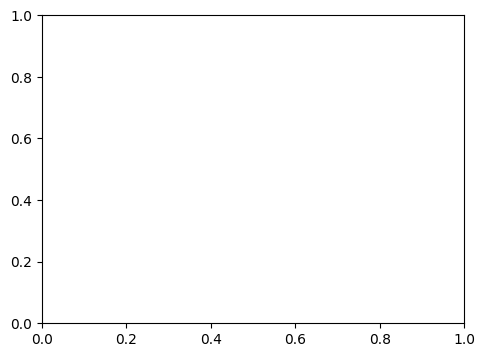

In [21]:
# 6. Save Model
torch.save(model.state_dict(), "gin_tox21.pt")
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_losses, label="Training Loss")
plt.subplot(122)
plt.plot(test_aucs, label="Test AUC")
plt.savefig("gin_performance.png")